In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np 
from tqdm.auto import tqdm,trange
import multiprocessing


In [34]:
class Environment():
    def __init__(self, arms: int, starts = None, non_stationary: bool = False):
        self.arms = arms
        self.means = np.zeros(arms,float) if starts is None else starts
        self.non_stationary = non_stationary
        self.optimal_over_time = []
        self.steps = 0
        self.optimal_steps = 0
        self.means_over_time = []


    def step(self, action: int):
        reward = np.random.normal(self.means[action],1.0)

        optimal_action = self.optimal_action()
        self.steps += 1
        self.optimal_steps += 1 if action in optimal_action else 0
        self.optimal_over_time.append(self.optimal_steps / self.steps)

        if self.non_stationary: self.means += np.random.normal(0,0.01,arms)

        return reward

    def optimal_action(self):
        return np.argwhere(self.means == np.amax(self.means)).flatten().tolist()

    def get_optimal_over_time(self):
        return self.optimal_over_time

In [35]:
class Value_Function():
    def __init__(self, arms: int):
        self.Qs = np.zeros(arms,float)
        self.visit_ns = np.zeros(arms,int)
    
    def update(self, arm: int, reward: float, alpha: float):
        self.visit_ns[arm] += 1
        self.Qs[arm] = self.Qs[arm] + alpha * (reward - self.Qs[arm])

    def get_values(self):
        return self.Qs

    def get_visits(self,arm):
        return self.visit_ns[arm]

In [36]:
def get_action(arms: int, epsilon: float, value_function: Value_Function):
    if np.random.uniform(0,1.0,1) < epsilon:
        return np.random.choice(range(arms))
    else:
        values = value_function.get_values()
        return np.random.choice([action_ for action_,value_ in enumerate(values) if value_ == np.max(values)])

In [37]:
def generate_starts(arms):
    return np.random.normal(0,1,arms)

In [ ]:
def alpha_generator(initial_alpha, value_n, alpha_type = "constant"):
    if alpha_type == "constant":
        return initial_alpha
    if alpha_type == "sample":
        return 1/value_n
    else:
        return 0.1

In [40]:
# runs = 10
# steps = 10_000_000
# epsilon = 0.1
# arms = 10
# alpha = 0.1
# starts = [0.2,-0.8,1.8,0.5,1.5,-1.3,-0.1,-1.0,0.7,-0.7]

# optimal_lines = []
# for _ in tqdm(range(runs)):
#     environment = Environment(arms, None, True)
#     value_function = Value_Function(arms)
#     for _ in range(steps):
#         action = get_action(arms, epsilon, value_function)
#         reward = environment.step(action)
#         value_function.update(action, reward, alpha)
#     optimal_lines.append(environment.get_optimal_over_time())
# optimals = np.mean(optimal_lines, axis = 0)

# plt.figure(figsize=(10,10))
# plt.axhline(y=0.8, color = 'orange', linestyle='--')
# plt.plot(optimals)
# plt.title("Percent Optimal Arm Chosen with Arm Random Mean Walks from 0 with Epsilon = 0.2")
# plt.ylabel("Cumulative Percent Optimal at Step")
# plt.xlabel("Step")
# plt.ylim(0,1.0)
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
# plt.savefig("../figures/exercise2-5/Percent_Optimal_Arm_Chosen_with_Arm_Random_Mean_walks_from_0_with_Epsilon_=_02.png")

In [53]:
runs = 50
steps = int(1e4)
arms = 10
initial_alpha = 0.1
alphas = ["constant","constant","constant","sample","sample","sample"]
epsilons = [0.0,0.1,0.01,0.0,0.1,0.01]

optimal_lines = []
for alphaChoice, epsilon in zip(alphas,epsilons):
    optimal_lines_per_alpha = []
    for _ in tqdm(range(runs)):
        starts = generate_starts(arms)
        environment = Environment(arms, starts, True)
        value_function = Value_Function(arms)
        for step in range(steps):
            action = get_action(arms, epsilon, value_function)
            reward = environment.step(action)
            alpha = alpha_generator(initial_alpha, value_function.get_visits(action), alphaChoice)
            value_function.update(action, reward, alpha)
        optimal_lines_per_alpha.append(environment.get_optimal_over_time())
    optimal_lines.append(np.mean(optimal_lines_per_alpha, axis = 0))

100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


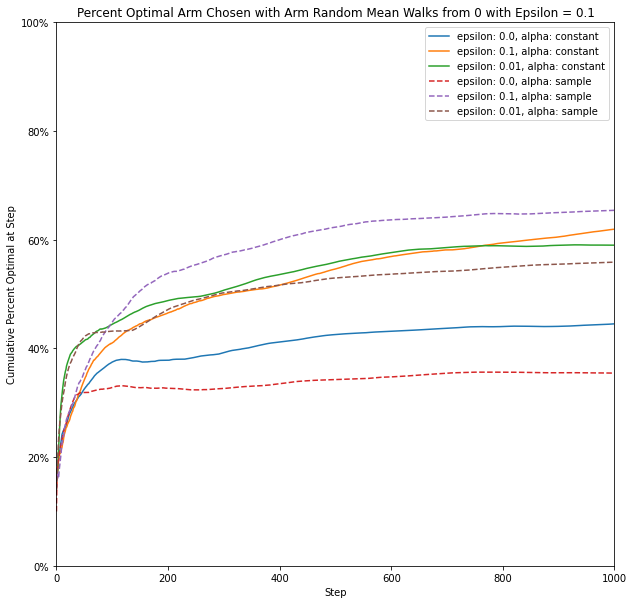

In [54]:
plt.figure(figsize=(10,10))
for optimals_i, optimals in enumerate(optimal_lines):
    plt.plot(optimals, label = "epsilon: " + str(epsilons[optimals_i]) + ", alpha: " + alphas[optimals_i], linestyle = "--" if alphas[optimals_i] == "sample" else "-")
plt.title("Percent Optimal Arm Chosen with Arm Random Mean Walks from 0 with Epsilon = 0.1")
plt.ylabel("Cumulative Percent Optimal at Step")
plt.xlabel("Step")
plt.ylim(0,1.0)
plt.xlim(0,1000)
plt.legend()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()